<a href="https://colab.research.google.com/github/JunYoung07/Hands-On_Machine_Learning/blob/main/2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3. 분류 (Classification)

## 3-1. MNIST 데이터 셋
* 70,000개의 작은 숫자 이미지
* 각 이미지마다 어떤 숫자를 나타내는 지 레이블되어 있음

In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

* 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가진다.
    * 데이터셋을 설명하는 **DESCR 키**
    * 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 **data 키**
    * 레이블 배열을 담은 **target 키**

In [2]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape     # 2차원 배열 (70000장의 샘플(row), 784개의 특성(columns))

(70000, 784)

In [4]:
y.shape     # 각각의 샘플의 레이블을 담고 있다.

(70000,)

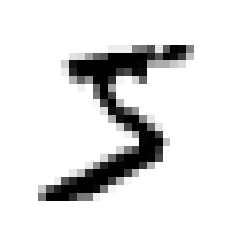

In [5]:
# 데이터 셋의 이미지 확인
import matplotlib as mlt
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)   # 첫번째 그림의 1차원 특성 784개를 2차원 28*28로 표현

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
# 레이블을 문자열에서 정수로 변환 (대부분의 머신러닝 알고리즘은 숫자를 기대한다.)
y = y.astype(np.uint8)  

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

* MNIST는 이미 훈련세트와 테스트 세트로 나누어둠
* 훈련세트의 경우 이미 섞여 있어 모든 교차 검증 폴드를 비슷하게 만든다.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3-2. 이진 분류기 훈련


* 숫자 5만 식별하기 '5-감지기'
    * '5'
    * '5 아님'
* 두 개의 클래스로 구분하는 **이진 분류기**

In [11]:
# 타깃 벡터 생성
y_train_5 = (y_train == 5)  # 5는 True고, 다른 숫자는 모두 False
y_test_t = (y_test == 5)

### 3-2-1. 확률적 경사 하강법 (**SGD**)
* Stochastic Gradient Descent 
* 한 번에 하나씩 훈련 샘플을 독립적으로 처리한다. (온라인 학습에 잘 맞는다)


In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)   # 훈련 시에 무작위성을 사용한다.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
# 숫자 5 이미지 감지
sgd_clf.predict([some_digit])  

array([ True])

In [14]:
# 성능 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

## 3-3. 성능 측정

### 3-3-1. 교차 검증을 사용한 정확도 측정
* 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 하는 경우 교차 검증 기능을 직접 구현한다.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [16]:
# 모든 이미지를 '5 아님'클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

> 이미지의 10%정도가  숫자 5이므로 무조건 90프로 이상의 성능을 가진다. 따라서 정확도를 분류기의 성능 지표로 선호하지 않는다.

### 3-3-2. 오차 행렬


* 분류기 성능 평가 지표
* 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
* 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.

In [18]:
# 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # cross_val_score()함수처럼 K-겹 교차 검증을 수행한다.

* **오차 행렬**
    * 오차행렬의 행은 **실제 클래스**이고 열은 **예측한 클래스**
    * 첫번째 행은 '5 아님', 두번째 행은 '5'
    * 첫번째 열은 음성, 두번째 열은 양성  

![ScreenShot](https://formal.hknu.ac.kr/handson-ml2/slides/images/homl03-02.png)

|Classify|Predicted Negative|Predicted Positive|
|-----|:---:|:---:|
|Negative Class|TN|FP|
|Positive Class|FN|TP|

In [19]:
# 오차행렬 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
# 완벽한 분류기의 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* **양성 예측의 정확도**
    * **정밀도**
$$정밀도 = \frac{TP}{TP+FP}$$
    * $TP$는 진짜 양성의 수, $FP$는 거짓 양성의 수
    * **재현율**
        * 정밀도는 다른 모든 양성 샘플을 무시하기 때문에 한계가 있다.
    * **민감도**, **진짜 양성 비율**
$$재현율 = \frac{TP}{TP + FN}$$

### 3-3-3. 정밀도와 재현율

* 사이킷런에서 제공하는 함수 사용
```
precision_score # 정밀도
recall_score  # 재현율
```

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)    # 정밀도 측정

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### $F_1$점수
* 정밀도와 재현율을 하나의 숫자로 만든다.
* 정밀도와 재현율의 **조화 평균**(harmonic mean)  

$$F_1 = \frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}} = 2 \times \frac{정밀도 * 재현율}{정밀도 \times 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}}$$
```
f1_score # f1점수 계산
```
* 정밀도와 재현율이 비슷한 분류기에서는 $F_1$점수가 높다
* **정밀도/재현율 트레이드오프**
    * 상황에 따라 정밀도가 높은 경우와 재현율이 높은 경우를 골라서 사용해야 한다.
        * 어린 아이를 위한 안전한 동영상 (높은 정밀도)
        * 좀도둑을 잡아내는 분류기 (높은 재현율)

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3-3-4. 정밀도/재현율 트레이드오프
* 정밀도와 재현율 상호 반비례
* 정밀도와 재현율 사이의 적절한 비율 찾기

#### SGDClassifier
* **결정함수**(decision function)을 통해 샘플의 점수를 계산
    * 이 점수가 **임계값**보다 크면 양성, 아니면 음성
![ScreenShot](https://formal.hknu.ac.kr/handson-ml2/slides/images/homl03-03.png)
* 임계값이 커질수록:
    * 정밀도 올라감
    * 재현율 떨어짐
* 사이킷런에서는 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.

In [24]:
# 샘플의 점수 얻기 
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0   # 임계값 = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000    # 임계값 = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### 적절한 임계값 선택

In [27]:
# 훈련센트의 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")    # 결정 점수 반환

In [28]:
# 가능한 모든 임계값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

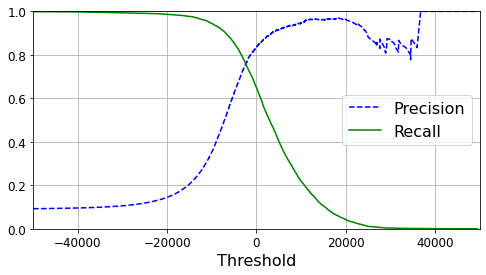

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> 임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있다.

In [30]:
(y_train_pred == (y_scores > 0)).all()

True

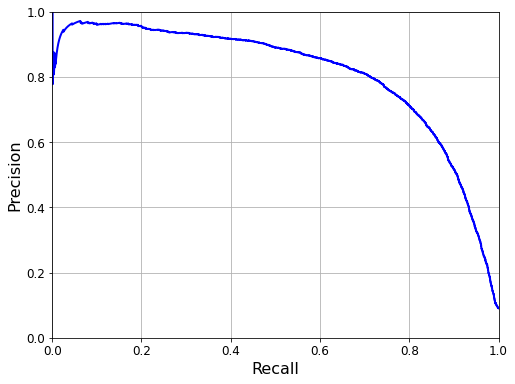

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

> 재현율 80%인 지점에서 정밀도가 급격히 감소한다.

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3-3-5. ROC 곡선

* **수신기 조작 특성**(ROC)
    * 정밀도/재현율 곡선과 매우 비슷하지만, 정림도에 대한 재현율 곡선은 아니다.
* **거짓 양성 비율**(FPR)에 대한 **진짜 양성 비율**(TPR)의 곡선
    * FPR: 양성으로 잘못 분류된 음성 샘플의 비율
        * 1에서 **진짜 음성 비율**(TNR)을 뺀 값
    * TNR: **특이도**라고 불리며, 음성으로 정확하게 분류한 음성 샘플의 비율
* **민감도**(재현율)에 대한 **1-특이도**그래프  
$$FPR = \frac{FP}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1 - TNR$$

In [35]:
# 여러 임계값에서의 TPR과 FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

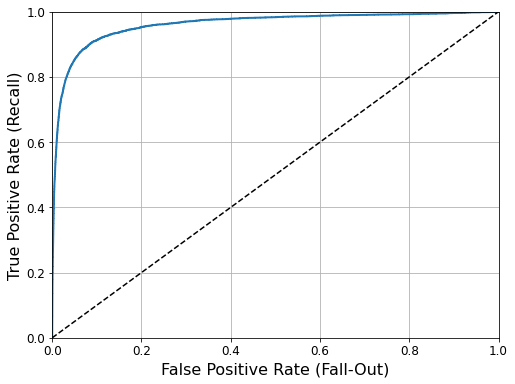

In [36]:
# TPR에 대한 FPR곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

* 재현율(TPR)이 높을수록 분류기가 만들어내는 거짓 양성(FPR)이 늘어난다.
* 좋은 분류기는 점선에서 최대한 멀리 떨어져있어야 한다.

#### 곡선 아래의 면적 (AUC)

* 분류기 비교 지표
    * 완벽한 분류기는 ROC의 AUC가 1
    * 완전한 랜덥 분류기는 0.5


In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### ROC 곡선 VS. PR 곡선
* ROC 곡선
* PR 곡선
    * 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 중요한 경우
    * 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여준다.

#### RandomForestClassifier VS. SGDClassifier
* 랜덤 포레스트 분류기에서 훈련 세트의 샘플에 대한 점수를 얻는 방법
```
predict_proba()
```
* 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [39]:
# roc_curve(): 레이블과 점수를 기대
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

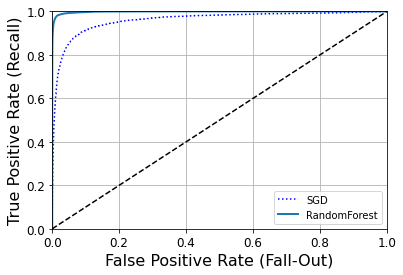

In [40]:
# ROC 곡선 그리기
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

> ROC 곡선 비교: 랜덤 포레스트 분류기가 SGD 분류기보다 AUC의 값이 크기 때문에 더 좋은 분류기이다.

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3-4. 다중 분류
* **multiclass classifier**는 둘 이상의 클래스를 구별할 수 있다.
    * SGD 분류기
    * 랜덤 포레스트 분류기
    * 나이브 베이즈
    * ...
* 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 있다.
    * 로지스틱 회귀
    * 서포트 벡터 머신 분류기
    * ...
    * 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
        * 일대다(OvR 또는 OvA)
    * 각 숫자의 조합마다 이진 분류기를 훈련시킨다.
        * 일대일(OvO)
            * 분류기 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요

In [42]:
# 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런은 자동으로 알고리즘에 따라 OvR 또는 OvO를 실행
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)   # 다중 분류이브로, y_train_5를 사용하지 않는다.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* 내부에서 OvO전략을 사용해 45개의 이진 분류기를 훈련
* 각각의 결정 점수 중 점수가 가장 높은 클래스를 선택

In [43]:
some_digit_scores = svm_clf.decision_function([some_digit]) # 샘플당 10개의 점수 반환
some_digit_scores   # 가장 높은 점수가 속한 클래스가 예측값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
np.argmax(some_digit_scores)    # 최댓값의 첫번째 인덱스 반환

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[5]

5

```
# sklearn 전략
OneVsOneClassifier   # OvO전략 선택
OneVsRestClassifier   # OvR전략 선택
```

In [47]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))   # 입력 스케일 조정
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3-5. 에러 분석

* 가능성이 높은 모델을 찾은 뒤, 이 모델의 성능을 향상시킬 방법 모색
* 만들어진 에러의 종류 분석
    1. cross_val_predict()
    2. 오차행렬 출력

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

<function matplotlib.pyplot.show(*args, **kw)>

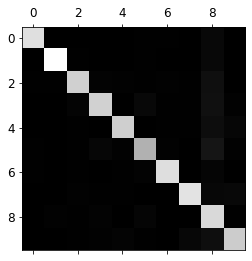

In [54]:
# 오차행렬을 이미지로 표현하기
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show

* 주대각선이 모두 밝으므로 이미지가 올바르게 분류되고 있음
* 숫자 5가 어둡다
    * 데이터셋의 숫자 이미지 5가 더 적다
    * 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다.
    * 두 가지 모두의 경우를 살펴본다


In [55]:
# 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.
rows_sums = conf_mx.sum(axis=1, keepdims=True)  # axis=1 -> 행을 더한다다 
norm_conf_mx = conf_mx / rows_sums

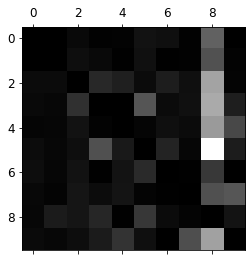

In [56]:
# 주대각선만 0으로 채워 그래프를 그린다
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 클래스 8열이 밝다
    * 많은 이미지가 8로 잘못 분류되고 있다.
* 클래스 8행이 어둡다
    * 실제 8이 적절히 8로 분류되었다.
* 3과 5가 서로 많이 혼동되고 있다.

#### 오차 행렬 분석 (성능 향상 방안)
* 8로 잘못 분류되는 것을 줄인다.
    * 8처럼 보이는(실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아 실제 8과 구분하도록 분류기 학습
    * 동심원을 세는 알고리즘 (8은 2개 6은 1개 0은 1개 ...)
* 개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을 얻을 수 있진만, 더 어렵고 시간이 오래 걸린다

In [57]:
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

* 3과 5의 구분이 어려운 이유
    * 선형모델인 SGD분류기를 사용
    * 픽셀마다 가중치를 적용하여 단순히 픽셀 강도에만 의존하기 때문
* 이미지의 위치나 회전 방향에 매우 민감하다
    * 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리한다.

## 3-6. 다중 레이블 분류

* 샘플마다 여러 개의 클래스 출력

### 얼굴 인식 분류기
* 한 사진에 여러 사람이 포함된 경우, 인식된 사람마다 하나씩 꼬리표(tag)를 붙여야 함
* 앨리스, 밥, 찰리의 포함여부를 확인 할 때, 밥이 없는 경우
    * ```[True, False, True]```출력

### 숫자 분류
* 7 이상인지 여부와 함께 홀수 여부도 동시 출력
* 5가 입력될 때:
    * ```[False, True]```출력

In [58]:
# k-최근점 이웃분류기 숫자분류기
from sklearn.neighbors import KNeighborsClassifier  # 다중 레이블 분류 지원

y_train_large = (y_train >= 7)  # 7보다 큰 값
y_train_odd = (y_train % 2 == 1)    # 홀수 값값
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

### 다중 레이블 분류기 평가 방법
* 모든 레이블의 가중치가 같다고 가정: 각 레이블의 $F_1$점수를 구하고 평균 점수 계산
* 가중치: 레이블에 클래스의 지지도(즉, 다킷 레이블에 속한 샘플 수)를 가중치로 사용 가능

In [60]:
# F1점수 평균 구하기
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 3-7. 다중 출력 분류

* **다중 출력 다중 클래스 분류**(multioutput-mlticlass classification)
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 (즉, 값을 2개 이상 가진다)


In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

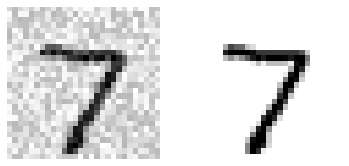

In [62]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

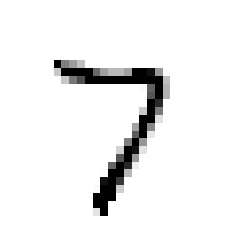

In [63]:
# 이미지 잡음 제거하기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)